In [1]:
import pennylane as qml
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCN
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import scatter
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ds = TUDataset("./data/PROTEINS", "PROTEINS")
ds.num_features, ds.num_classes, len(ds)

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


(3, 2, 1113)

In [3]:
ds = ds.shuffle()
break1 = int(len(ds) * 0.8)
break2 = int(len(ds) * 0.9)
training_data = ds[:break1]
validation_data = ds[break1:break2]
test_data = ds[break2:]
training_loader = DataLoader(training_data, batch_size=2048, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [4]:
def build_qfe_circuit(dev, n_qubits, n_layers):
    @qml.qnode(dev, interface="torch") #, diff_method="parameter-shift")
    def qfe_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits)) #qml.state() #[qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    return qml.qnn.TorchLayer(qfe_circuit, weight_shapes)

class QFE(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.wires = in_features
        self.dev = qml.device("default.qubit", wires=self.wires)
        self.qfe = build_qfe_circuit(self.dev, self.wires, 2)
    
    def forward(self, x):
        return self.qfe(x)

In [6]:
np.random.random(4)

array([0.3239735 , 0.93355653, 0.96461245, 0.82664045])

/tmp/ipykernel_37562/4228934677.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


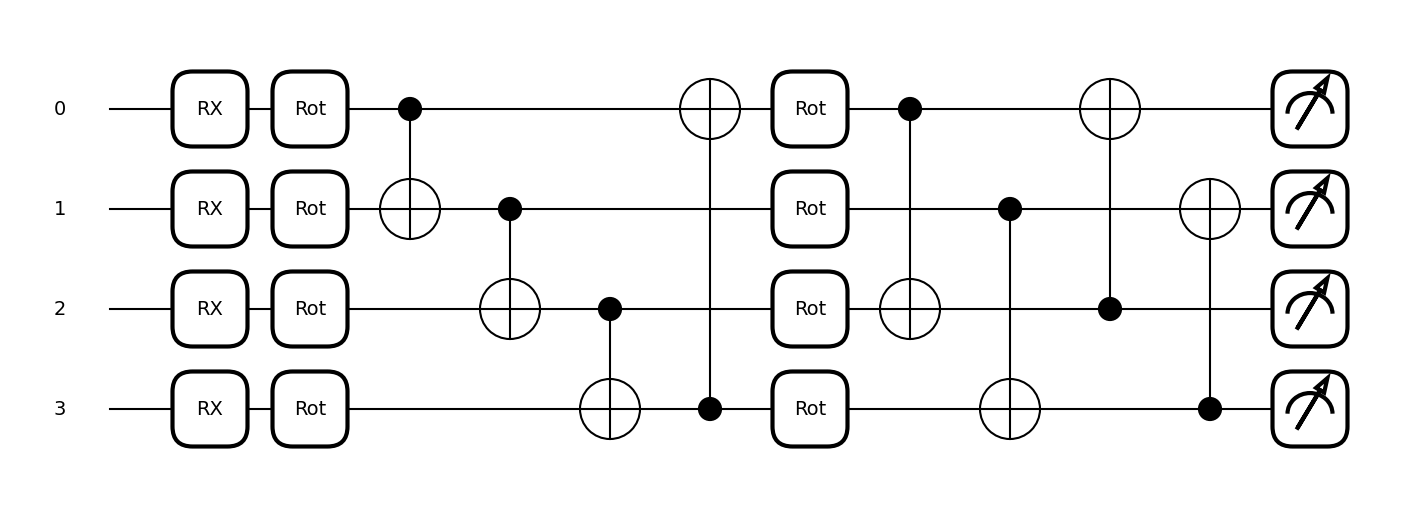

In [9]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev, interface="torch") #, diff_method="parameter-shift")
def qfe_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    return qml.probs(wires=range(4))
fig, ax = qml.draw_mpl(qfe_circuit, expansion_strategy="device")(np.random.random(4), np.random.random((2, 4, 3)))
fig.show()

In [5]:
class QFE_GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.qfe = QFE(in_features)
        # self.lin = torch.nn.Linear(in_features, 2**in_features)

        self.gcn = GCN(
            in_channels=2**in_features,
            hidden_channels=64,
            num_layers=4,
            dropout = 0.1,
            out_channels=out_features
        )
    
    def forward(self, data):
        x = data.x
        # x = self.lin(x)
        x = self.qfe(x.to(device="cpu")).to(device=x.device)

        x = self.gcn(x, data.edge_index, batch=data.batch)
        
        # x = global_mean_pool(x, data.batch)
        x = scatter(x, data.batch, dim=0, reduce="mean")
        x = F.log_softmax(x, dim=1)

        # out = torch.zeros(data.num_graphs, 2, device=x.device)

        # for i in range(data.num_graphs):
        #     out[i] = x[data.batch == i].mean(dim=0)
        
        # out = F.log_softmax(out, dim=1)
        # x = out
        
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QFE_GCN(3, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []

model.train()
for epoch in tqdm(range(60)):
    epoch_losses = []
    for batch in training_loader:
        optimizer.zero_grad()
        out = model(batch.to(device))
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        epoch_losses.append(loss.detach().cpu())
        optimizer.step()
    losses.append(epoch_losses)

100%|██████████| 60/60 [00:07<00:00,  8.18it/s]


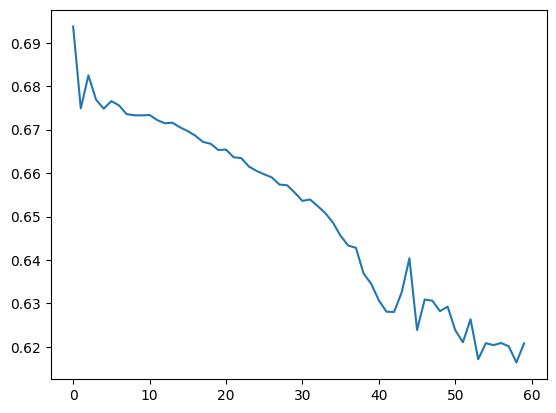

In [7]:
avg_losses = [np.mean(losses[i]) for i in range(len(losses))]
plt.plot(avg_losses)

In [8]:
model.eval()
correct = 0
total = 0
for batch in test_loader:
    out = model(batch.to(device))
    print(out.argmax(dim=1)) 
    print(batch.y)
    print()
    correct += sum(out.argmax(dim=1) == batch.y)
    total += len(batch.y)
print(f"Accuracy: {correct/total}")

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')

Accuracy: 0.7500000596046448


In [9]:
# Need to measure model performance varience.
performance = []
for i in range(15):
    print(f"Model {i}")
    model = QFE_GCN(3, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in tqdm(range(60)):
        for batch in training_loader:
            optimizer.zero_grad()
            out = model(batch.to(device))
            loss = F.cross_entropy(out, batch.y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch.to(device))
        print()
        correct += sum(out.argmax(dim=1) == batch.y)
        total += len(batch.y)
    print(f"Accuracy: {correct/total}")
    performance.append((correct/total).detach().cpu())

Model 0


100%|██████████| 60/60 [00:06<00:00,  8.68it/s]



Accuracy: 0.5803571939468384
Model 1


100%|██████████| 60/60 [00:06<00:00,  9.21it/s]



Accuracy: 0.7500000596046448
Model 2


100%|██████████| 60/60 [00:06<00:00,  9.18it/s]



Accuracy: 0.723214328289032
Model 3


100%|██████████| 60/60 [00:06<00:00,  8.86it/s]



Accuracy: 0.7410714626312256
Model 4


100%|██████████| 60/60 [00:06<00:00,  9.09it/s]



Accuracy: 0.7321428656578064
Model 5


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]



Accuracy: 0.7142857313156128
Model 6


100%|██████████| 60/60 [00:06<00:00,  9.21it/s]



Accuracy: 0.7410714626312256
Model 7


100%|██████████| 60/60 [00:06<00:00,  9.06it/s]



Accuracy: 0.6428571939468384
Model 8


100%|██████████| 60/60 [00:06<00:00,  9.40it/s]



Accuracy: 0.5803571939468384
Model 9


100%|██████████| 60/60 [00:06<00:00,  9.15it/s]



Accuracy: 0.7321428656578064
Model 10


 75%|███████▌  | 45/60 [00:05<00:01,  8.82it/s]


KeyboardInterrupt: 

(array([2., 0., 0., 1., 0., 0., 0., 1., 3., 3.]),
 array([0.58035719, 0.59732151, 0.61428577, 0.63125002, 0.64821434,
        0.66517866, 0.68214291, 0.69910717, 0.71607149, 0.7330358 ,
        0.75000006]),
 <BarContainer object of 10 artists>)

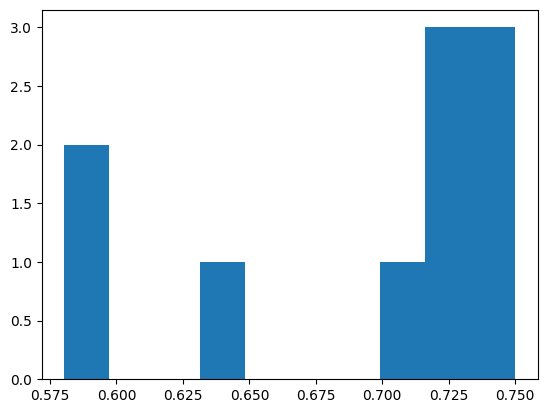

In [10]:
plt.hist(performance)

In [213]:
np.unique(performance, return_counts=True)

(array([0.55357146, 0.5803572 , 0.58928573, 0.6607143 , 0.7053572 ,
        0.71428573, 0.74107146, 0.7589286 , 0.7678572 , 0.77678573],
       dtype=float32),
 array([1, 2, 1, 1, 1, 1, 1, 2, 3, 2]))

In [12]:
from scipy.stats import bootstrap
res = bootstrap((performance,), np.mean, confidence_level=0.95)
m = (res.confidence_interval.low + res.confidence_interval.high)/2
e = (res.confidence_interval.high - res.confidence_interval.low)/2
print(f"{m} plus.minus {e}")

0.6852678954601288 plus.minus 0.04062500596046448
